## Facebook data Analysis

### Libraries 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import networkx as nx
import gzip
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as c
import random
import math
import re
import seaborn as sns
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import networkx.readwrite.gexf as gexf
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.readwrite import json_graph
import json
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import GraphRenderer,Range1d, HoverTool, StaticLayoutProvider, Circle, Plot
from bokeh.models.graphs import NodesOnly, from_networkx
from bokeh.palettes import magma, Reds

### Draw of greedy Communities

A community is a set of nodes with more links among them than to other parts of the network. Thus communities form separated groups of nodes, who share more edges between themselves than with other groups. 

The `draw_greedy_communities` algorithm gives a color to each community in the network, thus we can see each member of the group even if the layout of the graph isn't already representing it that way. To implement this method, we used a method called `greedy_modularity_communities` which was imported from the networkx.algorithms module. This algorithm unfortunately only gives a fronzenset of the groups. (The set type is mutable whereas the frozenset type is immutable and hashable.) That's why the `draw_greedy_communities` algorithm takes this groups in the frozenset, and gives independent colors to it. It then draws the network using `networkx.draw` method.

In [3]:
def draw_greedy_communities(g, layout, title, color):
    nodeList = tuple(g.nodes())
    pos = layout
    set_nodes = greedy_modularity_communities(g)
    list_nodes = [list(x) for x in set_nodes]
    node_color = [0]*len(g.nodes())
    n = -1
    count = 0
    print("There are", len(list_nodes), "groups!")
    for group in list_nodes[:]:
        n += 1
        for i in group[:]:
            count+=1
            node_color[i] = n
    node_color_tuple = node_color
    nx.draw(g, with_labels= False, pos = pos, node_size=100, nodelist = nodeList,
            node_color= node_color_tuple, cmap=color)
    plt.title(title)

### Imported Files from SNAP

**Data Source: ** https://snap.stanford.edu/data/egonets-Facebook.html

The data used in this project is from Facebook. The nodes represent the profiles of the participants, circles which are friends lists, and ego networks which are the networks for a particular user.

Because of the new law on data privacy (GDPR), the features of the profiles of the participants have been anonymized, thus we can only get a number for a particular feature, which will still help us group individuals by their respective features.

The files that were imported are the following:

- **facebook.tar.gz** : The anonymized facebook networks of 10 different participants.

- **facebook_combined.txt.gz** : The edges of all the ego networks combined.

Also, the _facebook.tar.gz_ file contains this sub files, each for the 10 different nodeId:

- **nodeId.edges** : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

- **nodeId.circles** : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

- **nodeId.feat** : The features for each of the nodes that appears in the edge file.

- **nodeId.egofeat** : The features for the ego user.

- **nodeId.featnames** : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

To read these files, you can use **PeaZip** to retrieve the data, such that you can read it and use it on Python. The data have already been put in the Binder, so no need to do this step.

In [4]:
edges107 = open('Data/facebook/107.edges', 'r')
circles107 = open("Data/facebook/107.circles", 'r')
featnames107 = open("Data/facebook/107.featnames", 'r')
feat107 = open("Data/facebook/107.feat", 'r')
egofeat107 = open("Data/facebook/107.egofeat", 'r')
f_comb = open('Data/facebook_combined.txt', 'r')

The two following methods are helpful to compute a graph such that the nodeId's of the network are mapped to indices for a list. This way the `draw_greedy_communities` method works well. 

In [5]:
def create_graph_edges_with_range_indices_and_counter(g, file, counter):
    #Create "count" edges
    G_tmp = nx.Graph()
    count = counter
    for string in file:
        if(count == 0):
            print("We computed the", counter,"edges")
            break;
        edge = string.split(" ")
        edge[1] = edge[1][:-1]
        G_tmp.add_edge(int(edge[0]), int(edge[1]))
        count = count - 1
    
    #Create nodes
    nodes = list(G_tmp.nodes())
    indices = list(range(len(nodes)))
    dict_map = dict(zip(nodes, indices))
    G = nx.Graph()
    G.add_nodes_from(dict_map.keys())
    
    #Create edges with indices of range(0, len(g.nodes))
    for edger in G_tmp.edges():
        g.add_edge(dict_map.get(edger[0]), dict_map.get(edger[1]))
    
def create_graph_edges_with_range_indices(g, file):
    #Create edges
    for string in file:
        edge = string.split(" ")
        edge[1] = edge[1][:-1]
        g.add_edge(int(edge[0]), int(edge[1]))
        
    #Create nodes
    nodes = list(g.nodes())
    indices = list(range(len(nodes)))
    dict_map = dict(zip(nodes, indices))
    G = nx.Graph()
    G.add_nodes_from(dict_map.keys())
    
    #Create edges with indices of range(0, len(g.nodes))
    G_1 = nx.Graph()
    for edge in g.edges():
        G_1.add_edge(dict_map.get(edge[0]), dict_map.get(edge[1]))
    g = G_1
    

We computed the 6000 edges


Text(0.5,1,'Fruchterman_reingold_layout')

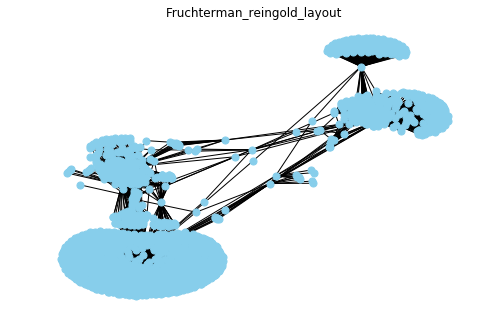

In [6]:
G_comb = nx.Graph()
create_graph_edges_with_range_indices_and_counter(G_comb, f_comb, 6000)
G_comb_pos = nx.fruchterman_reingold_layout(G_comb)
nx.draw(G_comb, with_labels=False, node_size=50, node_color="skyblue", pos = G_comb_pos)
plt.title("Fruchterman_reingold_layout")

Below is the same graph drawn by communities.

There are 10 groups!


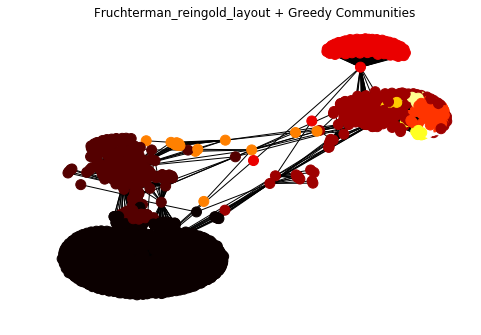

In [7]:
draw_greedy_communities(g = G_comb, layout=G_comb_pos, title= "Fruchterman_reingold_layout + Greedy Communities", color=plt.cm.hot)

## Bokeh

Let's try and plot the above graph by using the library of Bokeh.

The code below is helpful to draw the network in Bokeh such that the positions of the nodes aren't to close to each other. We thus see a better graph.

In [8]:
for a in G_comb_pos.values():
    a[0] = a[0]*100
    a[1] = a[1]*100

In [9]:
#Bokeh
plot = Plot(plot_height = 1000, 
           plot_width = 1000,
           x_range=Range1d(-100, 100), 
           y_range=Range1d(-100, 100))
plot.title.text = "Bokeh"
G_Bokeh = GraphRenderer()
nod = G_Bokeh.node_renderer
edg = G_Bokeh.edge_renderer
node_indices = list(G_comb.nodes())

nod.data_source.add(node_indices, 'index')
nod.glyph = Circle(size=20)


edg.data_source.data = dict(
    start=list(G_comb.edges())[:][0],
    end=list(G_comb.edges())[:][1])

index_hover = [
    ("name", "@index")
]

plot.add_tools(HoverTool(tooltips = index_hover))

graph_layout = G_comb_pos
G_Bokeh.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)

G_Bokeh.inspection_policy = NodesOnly()
plot.renderers.append(G_Bokeh)
output_notebook()
show(plot)

Loading BokehJS ...

## Facebook Ego Networks

Now that we have a big view of how our SNAP network looks like, let's take these above individual communities and view them independently. In our case we will first analyse the **nodeID** == **107**:

In [10]:
edges107 = 'Data/facebook/107.edges'
featnames107 = "Data/facebook/107.featnames"
feat107 = "Data/facebook/107.feat"
circles107 = "Data/facebook/107.circles"

### Methods

Creates a dictionary that has as keys the name of the circle, _circle#_, and as values the _IDnodes_ that are in this circle.

In [11]:
def read_circles_file(f):
    with open(f, 'r') as f:
        circles = []
        circles_indexes = []
        circles_list = []
        dic = {}
        for s in f:
            a = s.split("\t")
            a[-1] = a[-1][:-1]
            circles.append(a)
        for tupl in circles:
            circles_indexes.append(tupl[0])
            circles_list.append(tupl[1:])
        return dict(zip(circles_indexes, circles_list))

Creates a dictionnary that has as keys the _nodes_ (1045) of the ego-network of **nodeID == 107** and as values the _0/1 value_ for each feature (576).

In [12]:
def read_feat_file(f):
    with open(f, 'r') as f:
        feat = []
        feat_indexes = []
        feat_list = []
        for s in f:
            a = s.split(" ")
            a[-1] = a[-1][:-1]
            feat.append(list(map(int, a)))
        for ls in feat:
            feat_indexes.append(ls[0])
            feat_list.append(ls[1:])
        return dict(zip(feat_indexes, feat_list))

In [13]:
def draw_cycles(G):
    color_map = []
    n=0
    count = len(G.nodes())
    for ls in cycle_list:
        for i in ls:
            if (count == 0):
                break;
            count-=1
            color_map.append(6*n)
        n = n+1
    nx.draw(G, node_color = color_map, cmap = plt.cm.hot, pos = nx.fruchterman_reingold_layout(G))
    plt.show()

Computes the scalar product of the friends and non-friends of the ego-network of nodeID. It computes a scalar product for each feature of two friends/non-friends. Thus what we obtain is a plot which shows how much this feature links or not the friends/non-friends.

In [14]:
def plt_feature(feature):
    vec_friends = []
    vec_non_friends = []
    for b in feature:
        for c in feature:
            if g_friends.has_edge(b,c):
                vec_friends.append(np.dot(feature[b],feature[c]))
            else:
                vec_non_friends.append(np.dot(feature[b],feature[c]))
    x = ['friends']*len(vec_friends) + ['non_friends']*len(vec_non_friends)
    plt.scatter(x, vec_friends+vec_non_friends, marker = ".")

Plots how many friends/non-friends share a particular feature. 

In [15]:
def prod(x,y):
    return x*y
def plt_lines(dic):
    vec_friends = [0]*len(dic[0])
    vec_non_friends = [0]*len(dic[0])
    for (a,b) in g_friends.edges():
        c = list(map(prod, dic[a],dic[b]))
        vec_friends = list(map(sum, zip(c,vec_friends)))
    for (a,b) in g_non_friends.edges():
        c = list(map(prod, dic[a],dic[b]))
        vec_non_friends = list(map(sum, zip(c,vec_non_friends))) 
    return (vec_friends, vec_non_friends)

In [16]:
def list_of_possible_features(file):
    with open(file, 'r') as file:
        ls1 = []
        for line in file: 
            a = re.findall(r"[\w']+", line)
            b = a[1:-1]
            b.remove('anonymized')
            b.remove('feature')
            ls1.append(b)
        b_set = set(map(tuple,ls1))
        list_of_possible_features = list(map(list,b_set))
        return [" ".join(x) for x in list_of_possible_features]

In [17]:
def split_by_feature(dic, file, feature):
    with open(file, 'r') as file:
        ls = []
        c = []
        indices = []
        min_ind = 0
        max_ind = 0
        b = []
        for line in file:
            a = re.findall(r"[\w']+", line)
            b = a[1:-1]
            b.remove('anonymized')
            b.remove('feature')
            ls.append(b)
        for x in ls:
            c.append(" ".join(x))
        indices = [i for i, x in enumerate(c) if x == feature]
        min_ind = indices[0]
        max_ind = indices[-1]

        dico = dic.copy()
        for k in dic:
            dico[k] = dic[k][min_ind:(max_ind+1)]
        return dico

### Analysis of nodeID 107

Text(0.5,1,'G107 Graph Layout')

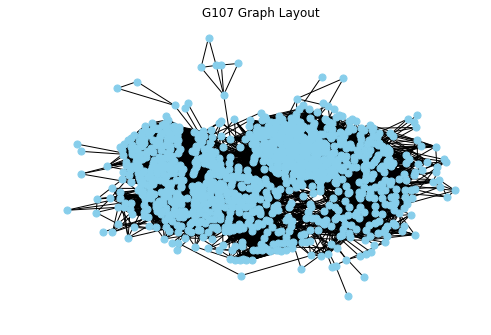

In [18]:
G107 = nx.Graph()
create_graph_edges_with_range_indices(G107, open(edges107, 'r'))
G107_pos = nx.kamada_kawai_layout(G107)
nx.draw(G107, with_labels=False, node_size=50, node_color="skyblue", pos = G107_pos)
plt.title("G107 Graph Layout")

Now let's identify the circles by reading the `107.circles` file. 

In [19]:
dict_cycles = read_circles_file(circles107)

Let's now draw our graph by giving a color to each node. The problem now is that the nodes in the circles can be repeated, thus one node could have 2 colors. What we did is remove the duplicate nodes, and keep them in only one circle.

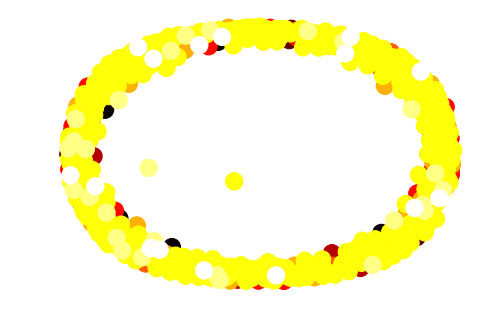

In [20]:
G_cycle = nx.Graph()
cycle_list = list(dict_cycles.values())

for ls in cycle_list:
    G_cycle.add_nodes_from(ls)

draw_cycles(G_cycle)

In [21]:
#Create graph and edges
g = nx.Graph()
with open(edges107, 'r') as f:
    for string in f:
        edge = string.split(" ")
        edge[1] = edge[1][:-1]
        g.add_edge(int(edge[0]), int(edge[1]))

Below is the dictionnary that will be helpful to read all the data file of **107feat**, which consists of 1045 nodes and 576 features for each of these nodes. For this dictionnary, we will also create 2 graphs, one which corresponds to all friends in the ego-network of nodeID 107, and one to all the non-friends in the ego-network of nodeID 107.

In [22]:
# Create dictionnary
dic1 = read_feat_file(feat107)

#Create corresponding graph
g_friends = nx.Graph()
g_non_friends = nx.Graph()
friends = []
non_friends = []
for j in dic1:
    for k in dic1:
        if k != j:
            if g.has_edge(j,k):
                g_friends.add_edge(j,k)
                friends.append(np.dot(dic1[j], dic1[k]))
            else:
                g_non_friends.add_edge(j,k)
                non_friends.append(np.dot(dic1[j], dic1[k]))

Now we shall try and compute features separately.

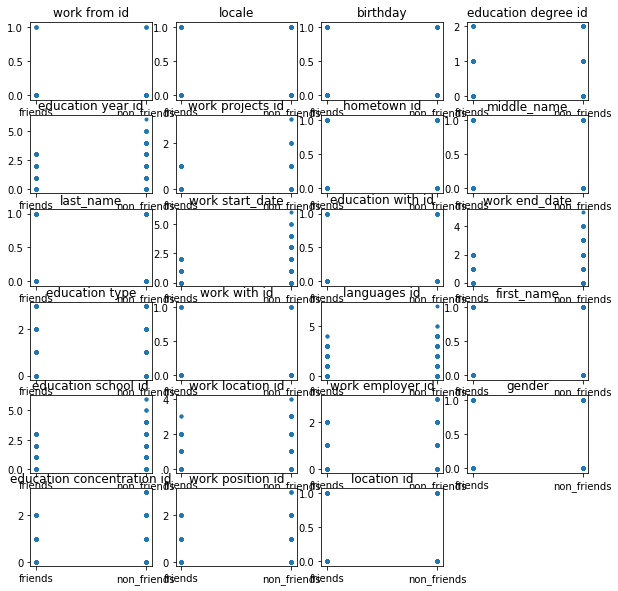

In [28]:
fig = plt.figure(figsize=(10,10))
feature_names = list_of_possible_features(featnames107)
for i in range(0, len(feature_names)):
    fig.add_subplot(6,4, i+1)
    dic_feature = split_by_feature(dic1, "Data/facebook/107.featnames", feature_names[i])
    plt_feature(dic_feature)
    plt.title(feature_names[i])

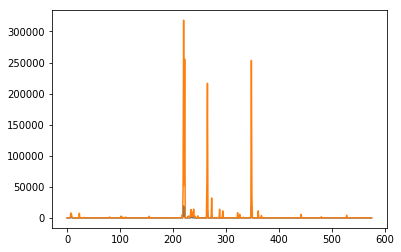

In [24]:
vec_friends, vec_non_friends = plt_lines(dic1)
plt.plot(vec_friends)
plt.plot(vec_non_friends)

The graph below is proportional to the number of friends/non-friends. Indeed, this way we see what is the probability to be friends/non_friends according to some features. And we see that the graph below  doesn't correspond to the one above.

Text(0.5,1,'Plot of nodeID 107 ego-network and its features')

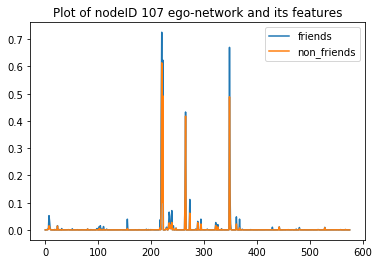

In [25]:
f1 = [x/len(g_friends.edges) for x in vec_friends]
plt.plot(f1, label = "friends")
f2 = [x/len(g_non_friends.edges) for x in vec_non_friends]
plt.plot(f2, label = "non_friends")
plt.legend()
plt.title("Plot of nodeID 107 ego-network and its features")

In [26]:
feature_names = list_of_possible_features(featnames107)

Now let's compute this in a clenear way where we can see all features and their relations:
Below we can see how the 

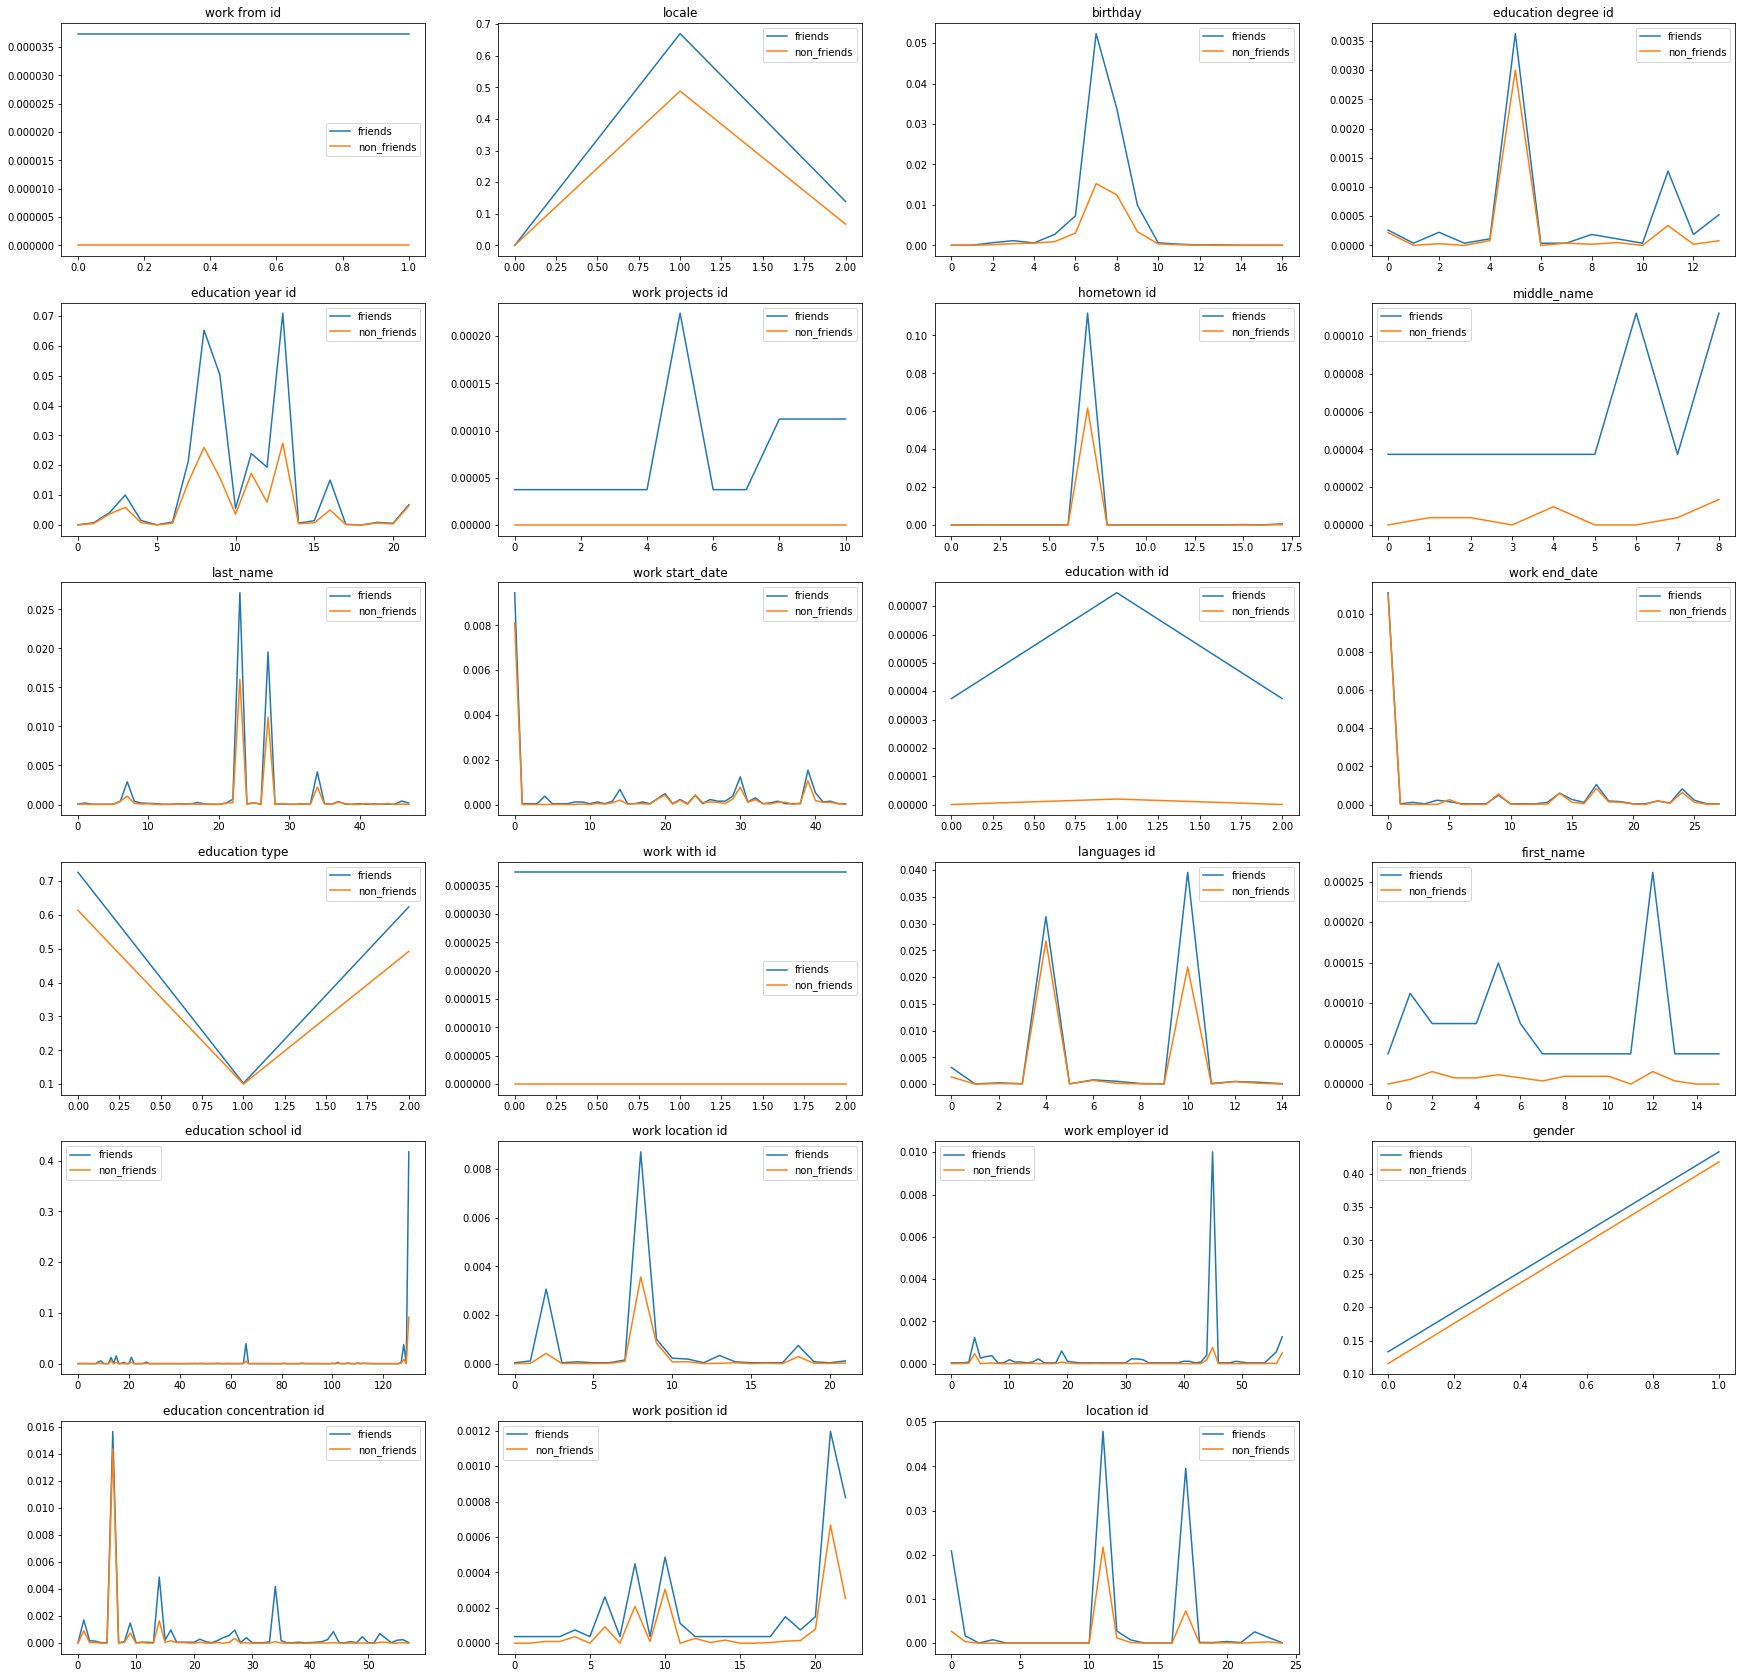

In [27]:
fig = plt.figure(figsize=(30,30))
for i in range(0, len(feature_names)):
    fig.add_subplot(6,4, i+1)
    dic_feature = split_by_feature(dic1, "Data/facebook/107.featnames", feature_names[i])
    a,b = plt_lines(dic_feature)
    f1 = [x/len(g_friends.edges) for x in a]
    f2 = [x/len(g_non_friends.edges) for x in b]
    plt.plot(f1, label = "friends")
    plt.plot(f2, label = "non_friends")
    plt.title(feature_names[i])
    plt.legend()